In [1]:
import os
import matplotlib.pyplot as plt
import scanpy as sc
import deepstkit as dt
import numpy as np

/data/hgh/anaconda3/envs/deepst-env/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [9]:
SEED = 0 

# adata = sc.read_h5ad('../data/MERFISH/MERFISH_0.09.h5ad')
# adata = sc.read_h5ad('../data/BaristaSeq/Slice_2_removed.h5ad')
adata = sc.read_h5ad('../data/osmfish/osmfish_remove_excluded.h5ad')
print(adata)
adata.var_names_make_unique()
N_DOMAINS = len(adata.obs['Region'].unique())

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region'
    uns: 'ClusterName_colors'
    obsm: 'spatial'


In [10]:
def _data_process(
    adata: sc.AnnData
) -> np.ndarray:
    """
    Preprocess spatial transcriptomics data
    
    Parameters:
    -----------
    adata : sc.AnnData
        Spatial transcriptomics data
    pca_n_comps : int
        Number of PCA components (default: 200)
        
    Returns:
    --------
    np.ndarray
        Processed data matrix
    """
    adata.raw = adata
    adata.X = adata.obsm["augment_gene_data"].astype(np.float64)
    
    # Normalization pipeline
    data = sc.pp.normalize_total(adata, target_sum=1, inplace=False)['X']
    data = sc.pp.log1p(data)
    data = sc.pp.scale(data)
    
    return data

In [11]:
# ========== Initialize Analysis ==========
# Set random seed and initialize DeepST
dt.utils_func.seed_torch(seed=SEED)
RESULTS_DIR = "./Results" 
# Create DeepST instance with analysis parameters
deepst = dt.main.run(
    save_path=RESULTS_DIR,
    task="Identify_Domain",  # Spatial domain identification
    pre_epochs=500,          # Pretraining iterations
    epochs=500,              # Main training iterations
    use_gpu=True             # Accelerate with GPU if available
)

# ========== Feature Engineering ==========
# Data augmentation (skip morphological if no H&E)
adata = deepst._get_augment(
    adata,
    spatial_type="BallTree",
    use_morphological = False  # Set True if using H&E features
)

# Construct spatial neighborhood graph
graph_dict = deepst._get_graph(
    adata.obsm["spatial"],
    distType="KDTree"        # Spatial relationship modeling
)

# # Dimensionality reduction

data = _data_process(
    adata
)

# ========== Model Training ==========
# Train DeepST model and obtain embeddings
deepst_embed = deepst._fit(
    data=data,
    graph_dict=graph_dict
)
adata.obsm["DeepST_embed"] = deepst_embed

# ========== Spatial Domain Detection ==========
# Cluster spots into spatial domains
adata = deepst._get_cluster_data(
    adata,
    n_domains=N_DOMAINS,     # Expected number of domains
    priori=True              # Use prior knowledge if available
)

Spatial weights calculated. Average neighbors: 30.0
Gene expression weights calculated.
Final weight matrix calculated and stored in adata.obsm['weights_matrix_all']


Finding adjacent spots: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


Step 1: Data augmentation completed
12.0000 neighbors per cell on average.
Step 2: Spatial graph computation completed
Running DeepST analysis...


Pretraining initial model: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
Training final model: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


Step 3: DeepST training completed
Memory usage: 1.34 GB
Total time: 0.57 minutes
Analysis completed successfully
Found resolution: 0.28 for 11 domains


In [12]:
adata

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region', 'leiden', 'DeepST_domain', 'DeepST_refine_domain'
    uns: 'ClusterName_colors', 'neighbors', 'leiden', 'DeepST_domain'
    obsm: 'spatial', 'weights_matrix_all', 'adjacent_data', 'augment_gene_data', 'DeepST_embed'
    obsp: 'distances', 'connectivities'

In [13]:
from sklearn import metrics
obs_df = adata.obs.dropna()
ARI = metrics.adjusted_rand_score(obs_df['DeepST_refine_domain'], obs_df['Region'])
NMI = metrics.normalized_mutual_info_score(obs_df['DeepST_refine_domain'], obs_df['Region'])
print('Adjusted rand index = %.4f' %ARI)

Adjusted rand index = 0.5973


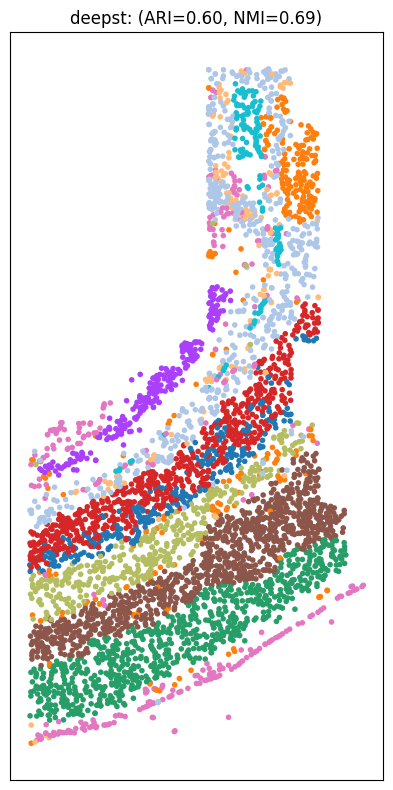

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sc.pl.spatial(adata, color='DeepST_refine_domain', ax=ax, show=False, spot_size=20, size=20, color_map='viridis',legend_loc=None)
# sc.pl.spatial(adata, color='mclust', ax=ax, show=False, spot_size=20)
ax.set_title('deepst: (ARI=%.2f, NMI=%.2f)' % (ARI, NMI))
ax.set_xlabel('')
ax.set_ylabel('')
output_dir = './deepst_ARI_NMI'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, "deepst_os_ARI.svg")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.tight_layout()

In [15]:
# 保存 adata 为 h5ad 文件
output_dir1 = ('./feature')
if not os.path.exists(output_dir1):
    os.makedirs(output_dir1)
output_path = os.path.join(output_dir1, f"os-DeepST.h5ad")
adata.write_h5ad(output_path)